# UERC Challange

In [1]:
%matplotlib inline

import sys
sys.path.append('/homes/yz4009/wd/gitdev/TFNet/')
import utils
import visualise
from networks import recognition

/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/scipy/sparse/compressed.py:730: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/vol/atlas/homes/yz4009/gitdev/menpofit/menpofit/math/fft_utils.py:20: RuntimeWarning: pyfftw is known to be buggy on your system, numpy.fft will be used instead. Consequently, all algorithms using ffts will be running at a slower speed.
  RuntimeWarning)


In [2]:
import tensorflow as tf
import data_provider
import menpo.io as mio
import scipy.io as sio
import os
import menpo
import scipy
import models
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from menpo.visualize import print_progress
from scipy.sparse import csr_matrix
from pathlib import Path

from tensorflow.python.platform import tf_logging as logging
from menpo.image import Image
from menpo.shape import PointCloud, PointUndirectedGraph
from menpowidgets import visualize_images
from sklearn.metrics import classification_report, accuracy_score
np.set_printoptions(3)
slim = tf.contrib.slim

In [3]:

"""Validate a face recognizer on the "Labeled Faces in the Wild" dataset (http://vis-www.cs.umass.edu/lfw/).
Embeddings are calculated using the pairs from http://vis-www.cs.umass.edu/lfw/pairs.txt and the ROC curve
is calculated and plotted. Both the model metagraph and the model parameters need to exist
in the same directory, and the metagraph should have the extension '.meta'.
"""
# MIT License
#
# Copyright (c) 2016 David Sandberg
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import argparse
import os
import sys
import re
import math
from scipy import misc
from sklearn.model_selection import KFold

from sklearn import metrics
from scipy.optimize import brentq
from scipy import interpolate
import tensorflow.contrib.slim as slim

### buid network

In [4]:
net_model = recognition.RecogNet()
net_model.num_classes = 397

In [4]:
with tf.Graph().as_default() as g:
    images = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='inputs')
    with tf.variable_scope('net'):
        with slim.arg_scope([slim.batch_norm, slim.layers.dropout], is_training=False):
            features, states = net_model._build_network(images)
            
            variables_to_restore = slim.get_variables_to_restore()
            saver = tf.train.Saver(variables_to_restore)
            model_path = '/homes/yz4009/wd/gitdev/TFNet/ckpt/ear/train/train_rec/model.ckpt-5194'

In [5]:
sess = tf.Session(graph=g)
saver.restore(sess, model_path)
print(model_path)

INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/ear/train/train_rec/model.ckpt-5194
/homes/yz4009/wd/gitdev/TFNet/ckpt/ear/train/train_rec/model.ckpt-5194


### Evaluation VGG EAR

In [147]:
def get_feature(path):
    offset = (256-224) / 2
    img = mio.import_image(path)
    try:
        img = img.crop_to_landmarks()
    except Exception as e:
#         print(e)
        pass
        
    img = utils.crop_image(img, img.centre(), img.diagonal()/350, [256,256], base=384)[0]
    img = img.crop((offset,offset),(offset+224,offset+224))
    
    if img.n_channels == 1:
        img = Image(np.concatenate([img.pixels]*3))
    
    feature = sess.run(features, feed_dict={'inputs:0':img.pixels_with_channels_at_back()[None,...]})
    return feature

#### protocol

In [36]:
db_path = Path('/homes/yz4009/wd/databases/ear/VGGEers-Recognition/')

In [40]:
# protocol = []
# for id_no, identity_path in enumerate(print_progress(list(db_path.glob('*')))):
#     if identity_path.is_dir():
#         for img in mio.import_images(identity_path):
#             protocol.append([id_no, img.path])
# mio.export_pickle(protocol, db_path/'protocol.pkl', overwrite=True)
protocol = mio.import_pickle(db_path/'protocol.pkl')

#### eval

In [49]:
feature_all = []
for id_no, p in print_progress(protocol):
    f = get_feature(p)
    feature_all.append([id_no, f])



[                    ] 4% (87/2058) - 00:01:48 remaining                        

/vol/atlas/homes/yz4009/gitdev/menpo/menpo/image/boolean.py:553: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  boolean_image = BooleanImage(warped.pixels.reshape(template_shape))


[====================] 100% (2058/2058) - done.                                 


In [ ]:
pred_results = []
gt_results = []

for id1,f1 in print_progress(feature_all):
    for id2,f2 in feature_all[1:]:
        pred_results.append(np.linalg.norm(f1-f2))
        gt_results.append(id1==id2)

pred_results = np.array(pred_results)
gt_results = np.array(gt_results)



In [ ]:
pred_results.mean()

true_index = np.argwhere(gt_results == True)
false_index = np.argwhere(gt_results == False)

true_index_19000 = true_index[np.random.choice(true_index.shape[0], 19000)]
false_index_19000 = false_index[np.random.choice(false_index.shape[0], 19000)]

sample_index = np.concatenate([true_index_19000,false_index_19000])

accuracy_score(pred_results[sample_index] < 1, gt_results[sample_index])

### Eval UERC

#### protocol

In [3]:
db_path = Path('/vol/atlas/databases/ear/UERC/UERC 2017 Dataset/Test Dataset')

In [4]:
# protocol = []
# for id_no, identity_path in enumerate(print_progress(list(db_path.glob('*')))):
#     if identity_path.is_dir():
#         for img in mio.import_images(identity_path):
#             protocol.append([id_no, img.path])
# mio.export_pickle(protocol, db_path/'protocol.pkl', overwrite=True)
protocol = mio.import_pickle(db_path/'protocol.pkl')

In [9]:
positive = []
negtive = []
for i,(i1, p1) in enumerate(protocol):
    for (i2, p2) in protocol[i+1:]:
        if i1 == i2:
            positive.append([p1,p2])
        else:
            negtive.append([p1,p2])
        

In [11]:
len(positive),len(negtive)

(51902, 45068348)

In [25]:
nfold = 10
n_each = 300

In [26]:
pos_index = np.random.choice(len(positive), nfold * n_each)
neg_index = np.random.choice(len(negtive), nfold * n_each)

In [27]:
pos_sample = [positive[i] for i in pos_index]
neg_sample = [negtive[i] for i in neg_index]

In [28]:
UERC_pair = '/vol/atlas/homes/yz4009/gitdev/facenet/data/pairs_UERC.txt'

In [30]:
with open(UERC_pair, "w") as f:
    f.write("%d %d\n"%(nfold, n_each))
    for ifold in range(nfold):
        for p1, p2 in positive[ifold*n_each:ifold*n_each+n_each]:
            name = int(p1.parent.stem)
            id1 = int(p1.stem)
            id2 = int(p2.stem)
            
            f.write("%d %d %d\n"%(name, id1, id2))
            
        for p1, p2 in negtive[ifold*n_each:ifold*n_each+n_each]:
            name1 = int(p1.parent.stem)
            name2 = int(p2.parent.stem)
            id1 = int(p1.stem)
            id2 = int(p2.stem)
            
            f.write("%d %d %d %d\n"%(name1, id1, name2, id2))
            
        

#### eval

In [ ]:
feature_all = []
for id_no, p in print_progress(protocol):
    f = get_feature(p)
    feature_all.append([id_no, f])

Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (1/9500) - 00:05:40 remaining                         Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (2/9500) - 00:05:08 remaining                         Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (3/9500) - 00:04:52 remaining                         Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (4/9500) - 00:04:45 remaining                         Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (5/9500) - 00:04:41 remaining                         Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (6/9500) - 00:04:36 remaining                         Cannot use None as a key as there are 0 landmark groups
[                    ] 0% (7/9500) - 00:04:35 remaining                         Cannot use None as a key as there are 0 landmark

/vol/atlas/homes/yz4009/gitdev/menpo/menpo/image/boolean.py:553: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  boolean_image = BooleanImage(warped.pixels.reshape(template_shape))


Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (109/9500) - 00:04:52 remaining                       Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (110/9500) - 00:04:53 remaining                       Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (111/9500) - 00:04:55 remaining                       Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (112/9500) - 00:04:57 remaining                       Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (113/9500) - 00:04:59 remaining                       Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (114/9500) - 00:05:06 remaining                       Cannot use None as a key as there are 0 landmark groups
[                    ] 1% (115/9500) - 00:05:05 remaining                       Cannot use None as a key as there are 0 landmark

In [151]:
pred_results = []
gt_results = []

for id1,f1 in print_progress(feature_all):
    for id2,f2 in feature_all[1:]:
        pred_results.append(np.linalg.norm(f1-f2))
        gt_results.append(id1==id2)

pred_results = np.array(pred_results)
gt_results = np.array(gt_results)



[====================] 100% (9500/9500) - done.                                 


In [155]:
print(pred_results.mean())

true_index = np.argwhere(gt_results == True)
false_index = np.argwhere(gt_results == False)

true_index_19000 = true_index[np.random.choice(true_index.shape[0], 19000)]
false_index_19000 = false_index[np.random.choice(false_index.shape[0], 19000)]

sample_index = np.concatenate([true_index_19000,false_index_19000])

71.9398


In [160]:
print(accuracy_score(pred_results[sample_index] < 0, gt_results[sample_index]))

0.5


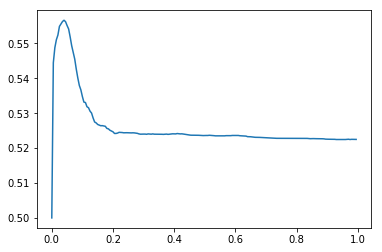

In [162]:
x = np.arange(0,1,0.005)
y = list(map(lambda xi: accuracy_score(pred_results[sample_index] < xi, gt_results[sample_index]), x))
plt.plot(x,y)

In [163]:
max(y)

0.55665789473684213

In [164]:
x1 =np.arange(4).reshape(2,2)
x2 =np.arange(6,12).reshape(3,2)



In [169]:
with tf.Session() as tsess:
    print(tsess.run(tf.reduce_sum(tf.square(x2[np.newaxis, :, :] - x2[:, np.newaxis, :]), axis=-1)).shape)

(3, 3)


In [98]:


def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs)

def get_paths(lfw_dir, pairs, file_ext):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])+'.'+file_ext)
            issame = True
        elif len(pair) == 4:
            path0 = os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])+'.'+file_ext)
            path1 = os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])+'.'+file_ext)
            issame = False
        if os.path.exists(path0) and os.path.exists(path1):    # Only add the pair if both paths exist
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs>0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    
    return path_list, issame_list


def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file

def load_model(model_dir, meta_file, ckpt_file):
    model_dir_exp = os.path.expanduser(model_dir)
    saver = tf.train.import_meta_graph(os.path.join(model_dir_exp, meta_file))
    saver.restore(tf.get_default_session(), os.path.join(model_dir_exp, ckpt_file))
    
def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = misc.imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
        if do_prewhiten:
            img = prewhiten(img)
        img = crop(img, do_random_crop, image_size)
        img = flip(img, do_random_flip)
        images[i,:,:,:] = img
    return images


def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    
    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff),1)
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        
        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])
          
        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc


  
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)
    
    diff = np.subtract(embeddings1, embeddings2)
    dist = np.sum(np.square(diff),1)
    
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
      
        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0
    
        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])
  
    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far

def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y 

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image
  
def flip(image, random_flip):
    if random_flip and np.random.choice([True, False]):
        image = np.fliplr(image)
    return image

def evaluate(embeddings, actual_issame, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far

In [99]:
lfw_pairs = '/homes/yz4009/wd/gitdev/facenet/data/pairs_UERC.txt'
lfw_dir = '/homes/yz4009/wd/databases/UERC_160_test/'
lfw_file_ext = 'png'
model_dir = '/homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/'
lfw_batch_size=100
lfw_nrof_folds=10

with tf.Graph().as_default():

    with tf.Session() as sess:
        
        images_placeholder = tf.placeholder(tf.float32, shape=(None, 160, 160, 3), name='inputs')
        net_model = recognition.RecogNet()
        net_model.num_classes = 397
        logist, status = net_model._build_network(images_placeholder)
        
        embeddings = status[0]
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        model_path = tf.train.latest_checkpoint(model_dir)
                
        saver.restore(sess, model_path)
        print(model_path)

        # Read the file containing the pairs used for testing
        pairs = read_pairs(os.path.expanduser(lfw_pairs))

        # Get the paths for the corresponding images
        paths, actual_issame = get_paths(os.path.expanduser(lfw_dir), pairs, lfw_file_ext)

        # Load the model
        print('Model directory: %s' % model_dir)
#         meta_file, ckpt_file = get_model_filenames(os.path.expanduser(model_dir))

#         print('Metagraph file: %s' % meta_file)
#         print('Checkpoint file: %s' % ckpt_file)
#         load_model(model_dir, meta_file, ckpt_file)

        # Get input and output tensors

        image_size = images_placeholder.get_shape()[1]
        embedding_size = embeddings.get_shape()[1]

        # Run forward pass to calculate embeddings
        print('Runnning forward pass on LFW images')
        batch_size = lfw_batch_size
        nrof_images = len(paths)
        nrof_batches = int(math.ceil(1.0*nrof_images / batch_size))
        emb_array = np.zeros((nrof_images, embedding_size))
        for i in range(nrof_batches):
            start_index = i*batch_size
            end_index = min((i+1)*batch_size, nrof_images)
            paths_batch = paths[start_index:end_index]
            images = load_data(paths_batch, False, False, image_size)
            feed_dict = {images_placeholder:images}
            emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)

        tpr, fpr, accuracy, val, val_std, far = evaluate(emb_array,
            actual_issame, nrof_folds=lfw_nrof_folds)

        print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
        print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

        auc = metrics.auc(fpr, tpr)
        print('Area Under Curve (AUC): %1.3f' % auc)
        eer = brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)
        print('Equal Error Rate (EER): %1.3f' % eer)



INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/model.ckpt-159900
/homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/model.ckpt-159900
Skipped 1656 image pairs
Model directory: /homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/
Runnning forward pass on LFW images
Accuracy: 0.868+-0.025
Validation rate: 0.03628+-0.01805 @ FAR=0.00146
Area Under Curve (AUC): 0.929
Equal Error Rate (EER): 0.139


### calculate features

In [56]:
text_path = '/vol/atlas/databases/ear/UERC/UERC 2017 Toolkit/databases/uerc-test/files.txt'
load_path = Path('/homes/yz4009/wd/databases/UERC_160_generate/')
model_dir = '/homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/'

In [60]:
with open(text_path, 'r') as f:
    files = [f.strip() for f in f.readlines()]

with tf.Graph().as_default():

    with tf.Session() as sess:
        
        images_placeholder = tf.placeholder(tf.float32, shape=(None, 160, 160, 3), name='inputs')
        net_model = recognition.RecogNet()
        net_model.num_classes = 397
        logist, status = net_model._build_network(images_placeholder)
        
        embeddings = status[0]
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        model_path = tf.train.latest_checkpoint(model_dir)

        saver.restore(sess, model_path)
        print(model_path)
    
        features = []
        
#         for f in print_progress(files):
#             image = load_data([str(load_path / f)], False, False, image_size)
#             feed_dict = {images_placeholder:image}
#             feature = sess.run(embeddings, feed_dict=feed_dict)
#             features.append(feature)
        
        images = np.concatenate([load_data([str(load_path / f)], False, False, image_size) for f in files])
        batch_size = 90
        for i in print_progress(list(range(0,len(images), batch_size))):
            batch_image = images[i:i+batch_size]
            feed_dict = {images_placeholder:batch_image}
            feature = sess.run(embeddings, feed_dict=feed_dict)
            features.append(feature)

INFO:tensorflow:Restoring parameters from /homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/model.ckpt-18603
/homes/yz4009/wd/gitdev/TFNet/ckpt/ear_vgg_512/train/train_rec/model.ckpt-18603
[====================] 100% (106/106) - done.                                   


In [61]:
len(features)

106

In [62]:
featM = np.concatenate(features)

In [64]:
sio.savemat('/vol/atlas/databases/ear/UERC/UERC 2017 Toolkit/feature512.mat', {'featM':featM})

In [65]:
featM = sio.loadmat('/vol/atlas/databases/ear/UERC/UERC 2017 Toolkit/feature512.mat', squeeze_me=True)
featM = featM['featM']

In [66]:
probe_ind = sio.loadmat('/vol/atlas/databases/ear/UERC/UERC 2017 Toolkit/probe_ind.mat', squeeze_me=True)
probe_ind = probe_ind['ind'] - 1

In [67]:
probeM = featM[probe_ind]

In [68]:
probeM.shape

(7442, 512)

In [69]:
featM.shape

(9500, 512)

In [89]:
sim_matrix_py = np.zeros((len(probeM),len(featM)))
for i,p in enumerate(print_progress(probeM)):
    for j,f in enumerate(featM):
        sim_matrix_py[i,j] = np.sum(np.square(p-f))
        
    

[====================] 100% (7442/7442) - done.                                 


In [90]:
sio.savemat('/vol/atlas/databases/ear/UERC/UERC 2017 Toolkit/sim_matrix.mat', {'sim_matrix':sim_matrix_py})

In [91]:
sim_matrix_py.max()

2.9799003601074219

In [70]:
sim_matrix_py = np.sum(np.square(probeM[:,None,:] - featM[None,:,:]), -1)

MemoryError: 

In [ ]:
sim_matrix_py.shape

In [74]:
sim_matrix_mat = sio.loadmat('/vol/atlas/databases/ear/UERC/UERC 2017 Toolkit/sim_matrix.mat', squeeze_me=True)
sim_matrix_mat = sim_matrix_mat['sim_matrix']

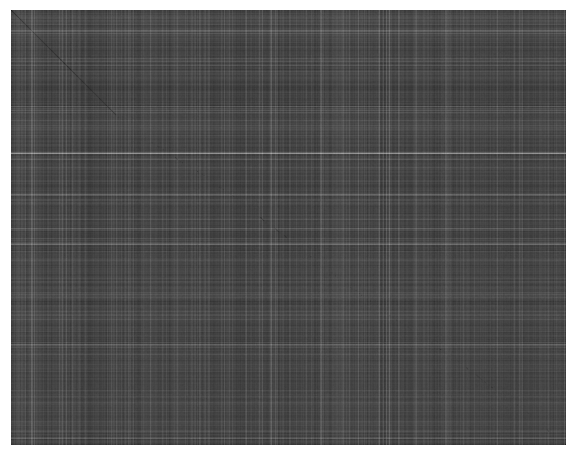

In [75]:
Image(sim_matrix_mat).rescale(0.1).view()

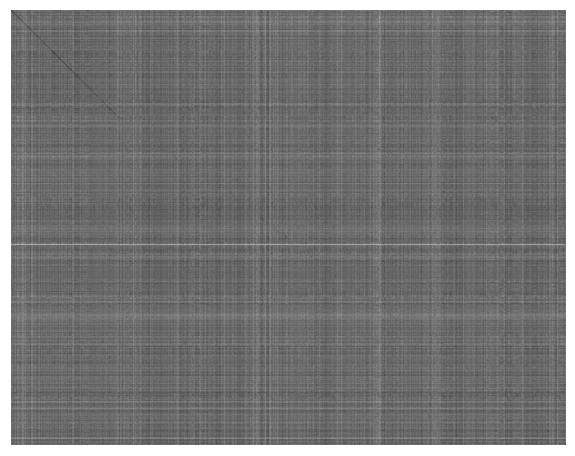

In [24]:
Image(sim_matrix_py).rescale(0.1).view()

In [27]:
sim_matrix_mat - sim_matrix_py

-1.3438097824780559e-07

In [131]:
random_image = Image(np.random.choice(255,3*128*128).reshape(3,128,128)/255)

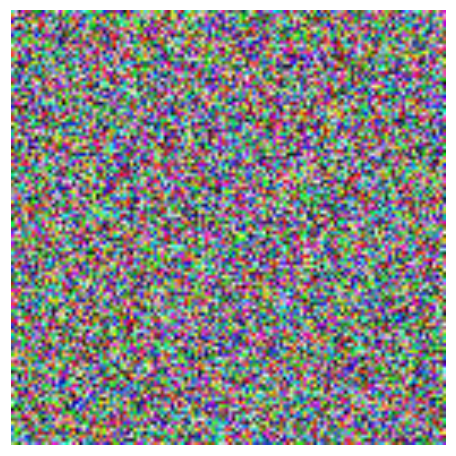

In [132]:
random_image.view()

(640, 512, 3)


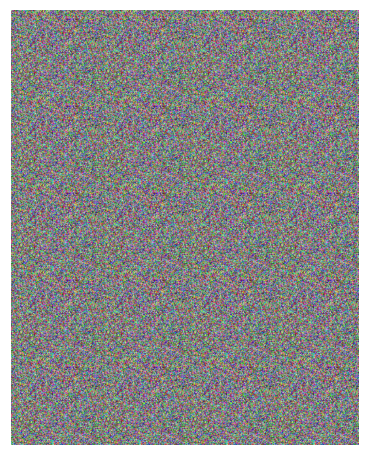

In [135]:
with tf.Session() as sess:
    w = 4
    h = 5
    tfimg = tf.tile(random_image.pixels_with_channels_at_back()[None,...],[70,1,1,1])[:w*h]
    img_grid = sess.run(
        tf.reshape(tf.transpose(tf.reshape(tfimg, [w,h*128,128,3]), [1,0,2,3]), [h*128,w*128,3])
    )
    print(img_grid.shape)
    Image.init_from_channels_at_back(img_grid).view()